# Task A: Deep Learning for ECG Heartbeat Classification

Develop  a  deep  learning  model  that  can  accurately  classify  heartbeats  from  ECG  signals.  You  are 
encouraged  to  explore  different  neural  network  architectures  and  techniques,  going  beyond  simple 
feedforward networks. 

## Checking for CUDA compatibility

In [1]:
import torch
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get current CUDA device index (if available)
if torch.cuda.is_available():
    print("Current CUDA device index:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA devices found.")

PyTorch version: 2.5.0+cu118
CUDA available: True
Current CUDA device index: 0
CUDA device name: NVIDIA GeForce RTX 3070


In [2]:
import pandas as pd
import numpy as np
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
dataframes = {}
directory_path = 'Arrhythmia_Dataset'
all_files = os.listdir(directory_path)

for file in os.listdir(directory_path):
    if file.endswith('.csv'):
        file_path = os.path.join(directory_path, file)
        # Remove the .csv extension for the DataFrame name
        df_name = os.path.splitext(file)[0]
        dataframes[df_name] = pd.read_csv(file_path)


C:\Users\randa\AppData\Local\Temp\ipykernel_18004\2393702289.py:17: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[df_name] = pd.read_csv(file_path)


In [3]:
print(dataframes.keys())


dict_keys(['INCART 2-lead Arrhythmia Database', 'MIT-BIH Arrhythmia Database', 'MIT-BIH Supraventricular Arrhythmia Database', 'Sudden Cardiac Death Holter Database'])


In [4]:
data_df = dataframes['MIT-BIH Arrhythmia Database']

## Splitting into features and class lables

In [5]:
x_data = data_df.iloc[:, 2:]
y_label = data_df[['type']]

In [6]:
y_label.value_counts()

type
N       90083
VEB      7009
SVEB     2779
F         803
Q          15
Name: count, dtype: int64

In [7]:
print(x_data.shape)
print(y_label.shape)

(100689, 32)
(100689, 1)


Classes: N (Normal), VEB (Ventricular ectopic beat), SVEB (Supraventricular ectopic beat), F (Fusion beat), and Q (Unknown beat). 

In [8]:
# y_label.replace(['VEB', 'SVEB', 'F', 'Q'], 'arrhythmia', inplace=True)
# y_label.replace(['N'], 'normal', inplace=True)

In [9]:
# y_label.value_counts()

In [10]:
class CNN1D(nn.Module):
    def __init__(self, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3)
        
        # Update this based on your input size after the conv/pooling layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 2, 256)  # Calculate output_length based on your input
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [11]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_label)  # Encode labels without replacement
num_classes = len(label_encoder.classes_)  # Use the number of unique classes
y = np.eye(num_classes)[y] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y, test_size=0.2, random_state=42)

# We add an additional dimension to make it suitable for 1D CNN.
X_train = np.expand_dims(X_train, axis=1)  # Change axis from 2 to 1
X_test = np.expand_dims(X_test, axis=1)    # Change axis from 2 to 1

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()  # Ensure the data is of float type
X_test_tensor = torch.tensor(X_test).float()    # Ensure the data is of float type
y_train_tensor = torch.tensor(y_train).long()   # Ensure labels are long type
y_test_tensor = torch.tensor(y_test).long()   

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

c:\Users\randa\OneDrive\Documents\GitHub\Neural-Networks-Project\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
print(len(label_encoder.classes_))

5


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_encoder.classes_)
model = CNN1D(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters())

# Train the model
train_acc = []  
test_acc = []
EPOCHS = 10
# Training loop
for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels.argmax(dim=1))  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels.argmax(dim=1)).sum().item()

    # Compute and store training accuracy for the epoch
    train_accuracy = correct_train / total_train
    train_acc.append(train_accuracy)

    print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {running_loss / len(train_loader):.4f}, Training Accuracy: {train_accuracy:.4f}')

    # Evaluate the model after each epoch
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        correct_test = 0
        total_test = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels.argmax(dim=1)).sum().item()

        accuracy = correct_test / total_test  # Calculate test accuracy
        test_acc.append(accuracy)  # Store accuracy for this epoch
        print(f'Epoch [{epoch + 1}/{EPOCHS}], Test Accuracy: {accuracy:.4f}')


# Create an array for epoch indices
# epoch_indices = np.arange(EPOCHS)



Epoch [1/10], Loss: 0.2498, Training Accuracy: 0.9346
Epoch [1/10], Test Accuracy: 0.9436
Epoch [2/10], Loss: 0.1805, Training Accuracy: 0.9485
Epoch [2/10], Test Accuracy: 0.9504
Epoch [3/10], Loss: 0.1495, Training Accuracy: 0.9557
Epoch [3/10], Test Accuracy: 0.9589
Epoch [4/10], Loss: 0.1200, Training Accuracy: 0.9639
Epoch [4/10], Test Accuracy: 0.9666
Epoch [5/10], Loss: 0.0962, Training Accuracy: 0.9724
Epoch [5/10], Test Accuracy: 0.9746
Epoch [6/10], Loss: 0.0882, Training Accuracy: 0.9750
Epoch [6/10], Test Accuracy: 0.9772
Epoch [7/10], Loss: 0.0782, Training Accuracy: 0.9779
Epoch [7/10], Test Accuracy: 0.9800
Epoch [8/10], Loss: 0.0741, Training Accuracy: 0.9795
Epoch [8/10], Test Accuracy: 0.9800
Epoch [9/10], Loss: 0.0682, Training Accuracy: 0.9804
Epoch [9/10], Test Accuracy: 0.9816
Epoch [10/10], Loss: 0.0659, Training Accuracy: 0.9814
Epoch [10/10], Test Accuracy: 0.9823


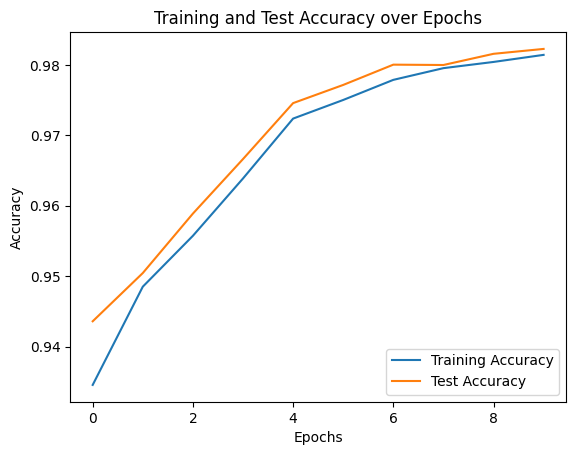

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(EPOCHS), train_acc, label='Training Accuracy')
plt.plot(np.arange(EPOCHS), test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend(loc='lower right')
plt.show()

In [15]:
model_path = "./model/cnn_model.pth"
# torch.save(model.state_dict(), model_path)
# print(f"Model saved to {model_path}")

In [16]:
loaded_model = CNN1D(num_classes).to(device)  # Reinitialize model with the same architecture
loaded_model.load_state_dict(torch.load(model_path, weights_only=True))

print("Model loaded successfully.")

sample_inputs = X_test_tensor[:20]  # Take the first 5 samples
sample_inputs = sample_inputs.to(device)  # Move to the appropriate device

with torch.no_grad():
    # Forward pass through the model for all sample inputs
    outputs = loaded_model(sample_inputs)
    _, predicted_classes = torch.max(outputs, 1)  # Get the predicted classes

# Decode the predicted classes to the original labels
predicted_labels = label_encoder.inverse_transform(predicted_classes.cpu().numpy())  # Move to CPU for numpy conversion

# Print predicted labels for each sample
for i, label in enumerate(predicted_labels):
    print(f"Predicted class for sample {i + 1}: {label}")


Model loaded successfully.
Predicted class for sample 1: N
Predicted class for sample 2: N
Predicted class for sample 3: N
Predicted class for sample 4: SVEB
Predicted class for sample 5: N
Predicted class for sample 6: N
Predicted class for sample 7: N
Predicted class for sample 8: N
Predicted class for sample 9: N
Predicted class for sample 10: N
Predicted class for sample 11: N
Predicted class for sample 12: N
Predicted class for sample 13: N
Predicted class for sample 14: N
Predicted class for sample 15: N
Predicted class for sample 16: N
Predicted class for sample 17: N
Predicted class for sample 18: N
Predicted class for sample 19: N
Predicted class for sample 20: N
